In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader

# Load model and data

In [4]:
#model_idx = 'hd5-860835'
model_idx = 'hd5-6552443152'

In [5]:
with open(f'training/{model_idx}/config.json') as f:
    config = json.load(f)
data_train, data_val, data_test = util.dataset_from_config(config)
model = util.model_from_config(config)

/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:410: RuntimeWarning: invalid value encountered in less
  idx_removed = np.where(np.logical_and((track_length < min_track_length), has_track_length))[0]
/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:416: RuntimeWarning: invalid value encountered in greater
  idx_removed = np.where(np.logical_and((cascade_energy > max_cascade_energy), has_track_length))


After Track Length filter 1094579 / 1762366 events remain.
After Cascade Energy filter 956781 / 1762366 events remain.
Reduced dataset to 284650 samples per class (569300 / 1762366)


In [6]:
if torch.cuda.is_available():
        model = model.cuda()
model.load_state_dict(torch.load(f'training/{model_idx}/model_1'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [7]:
test_loader = DataLoader(data_test, batch_size=config['training']['batch_size'], shuffle=config['dataset']['shuffle'], collate_fn=data_test.collate, drop_last=False)

In [8]:
metrics = defaultdict(float)
y_pred = np.zeros(len(test_loader.dataset))
y_true = np.zeros(len(test_loader.dataset))
total_loss = 0
model.eval()
for batch_idx, (inputs, y_i) in enumerate(test_loader):
    print(f'\rEvaluating {batch_idx + 1} / {len(test_loader)}', end='\r')
    y_pred_i = model(*inputs)
    y_pred[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_pred_i.data.cpu().numpy().squeeze()
    y_true[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_i.data.cpu().numpy().squeeze()

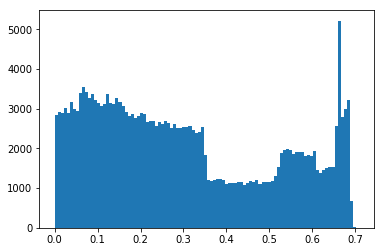

In [9]:
y_model = (y_pred >= .5).astype(np.int).flatten()
_ = plt.hist(y_pred, bins=100)

In [10]:
delta_llh = np.array(data_test.file['DeltaLLH'])[data_test._idxs]
y_baseline = (delta_llh >= 2.0).astype(np.uint8)

In [11]:
logits_model = y_pred
y_pred = (logits_model >= .5).astype(np.uint8)
acc_model = (y_pred == data_test.targets).sum() / y_pred.shape
acc_baseline = (y_baseline == data_test.targets).sum() / y_baseline.shape
acc_model, acc_baseline

(array([0.46628385]), array([0.61664132]))

# Check integrity of tracks in data

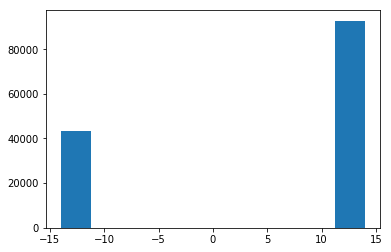

In [12]:
track_idx = data_test.targets > 0
_ = plt.hist(data_test.file['PDGEncoding'][track_idx])

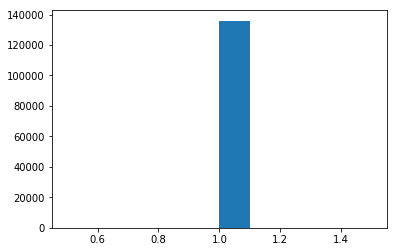

In [13]:
_ = plt.hist(data_test.file['InteractionType'][track_idx])

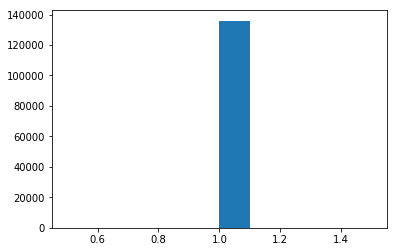

In [14]:
has_no_track_length = np.isnan(data_test.file['TrackLength'])
_ = plt.hist(data_test.targets[~has_no_track_length])

In [15]:
np.unique(data_test.file['PDGEncoding'][~has_no_track_length], return_counts=True)

(array([-14.,  14.]), array([43215, 92740]))

False

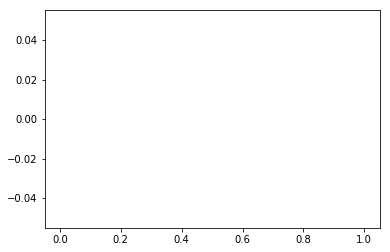

In [16]:
mask = (~np.isnan(data_test.file['TrackLength'])).copy()
mask[data_test.targets > 0] = False

track_lengths = data_test.file['TrackLength'][mask]
plt.hist(track_lengths, bins=200)

mask.any()

## Predict model on all data that was discarded during filtering

0.525

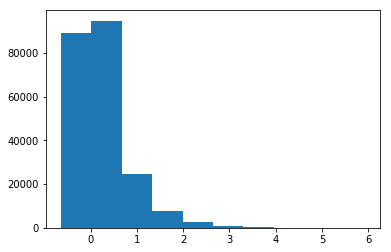

In [17]:
charge = np.array(data_test.file['TotalCharge'])[data_test._idxs]
pdg_encodings = np.array(data_test.file['PDGEncoding'])[data_test._idxs]
interaction_types = np.array(data_test.file['InteractionType'])[data_test._idxs]
#_ = plt.hist(np.log(np.array(data_train.file['TotalCharge'])))
plt.hist(np.log(charge))
min(charge)

In [18]:
def binned_ppr(y_pred, y_gnd, charge, bins=50):
    """ Calculates the ppr binned in charges. 
    
    Parameters:
    -----------
    y_pred : ndarray, shape [N]
        Predictions.
    y_gnd : ndarray, shape [N]
        Ground truths.
    charge : ndarray, shape [N]
        Charge values (to be binned.)
    bins : int, optional
        The number of bins.
    
    Returns:
    --------
    ppr : ndarray, shape [bins + 1]
        Positive predicted values for each bin.
    sigma_ppr : ndarray, shape [bins + 1]
        Uncertainty of predicted positive values for each bin.
    bins : ndarray, shape [bins]
        Bin edges.
    """
    log_charge = np.log(charge)
    # Bin all charges
    bin_counts, bins = np.histogram(log_charge, bins=bins, range=(0, 3.0))
    # Bin positive predictions
    pos_bin_counts, _ = np.histogram(log_charge[y_pred > 0], bins=bins)
    ppr = pos_bin_counts / bin_counts
    
    # Calculate uncertainty
    sigma_bin_counts = np.sqrt(bin_counts)
    sigma_pos_bin_counts = np.sqrt(pos_bin_counts)
    
    sigma_ppr = np.sqrt(
        ppr**2 * ((sigma_bin_counts / bin_counts)**2 + (sigma_pos_bin_counts / pos_bin_counts)**2))
    return ppr, sigma_ppr, bins

In [19]:
def ppr_plot(y_pred, y_gnd, charges, pdg_encodings, interaction_types, title, plots):
    """ Creates subplots for the ppr by neutrino flavour (and interaction type). """
    pgd_encodings = np.abs(pdg_encodings)
    fig = plt.figure(figsize=(20, 10))
    plt.xticks(fontsize=24)
    plt.xscale('log')
    
    for plot_label in plots:
        color, pdg_encoding, interaction_type = plots[plot_label]
        if interaction_type is None:
            mask = pdg_encodings == pdg_encoding
        else:
            mask = np.logical_and((pdg_encodings == pdg_encoding), (interaction_types == interaction_type))
                           
        ppr, sigma, bin_edges = binned_ppr(y_pred[mask], y_gnd[mask], charges[mask], bins=25)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        plt.fill_between(
            bin_centers,
            ppr - sigma,
            ppr + sigma,
            color=color,
            alpha=.1,
            step='pre',
        )
        plt.errorbar(
            bin_centers,
            ppr,
            color=color,
            label=plot_label,
            linestyle='steps',
        )
    plt.xlabel('log(Integrated Charge) (pe)', fontsize=20)
    plt.ylim(0, 1)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.0), fontsize=20)
    plt.title(title, fontsize=24)

In [20]:
plots = {
    #'nue NC' : ('blue', 12, 2),
    #'nue CC' : ('black', 12, 1),
    'numu CC' : ('green', 14, 1),
    'numu NC' : ('red', 14, 2),
    'nue' : ('blue', 12, None),
    'nutau' : ('purple', 16, None),
    #'nutau NC' : ('green', 16, 2),
    #'nutau CC' : ('brown', 16, 1)

}

/usr/local/lib/python3.6/dist-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib/legend.py:497: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


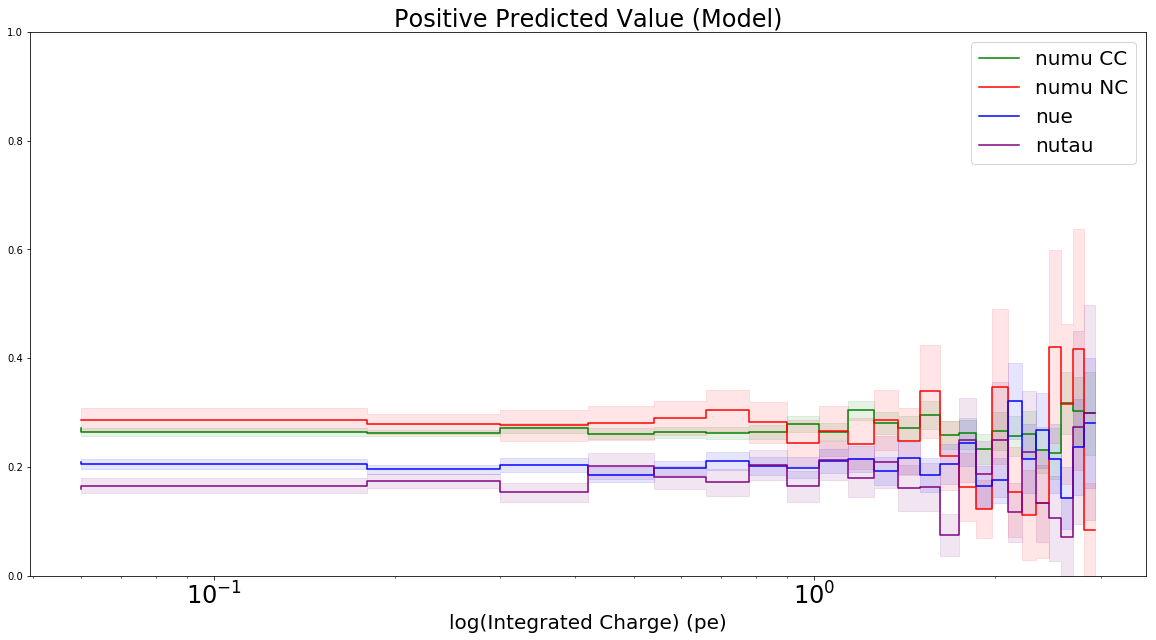

In [21]:
ppr_plot(y_model, data_test.targets, charge, pdg_encodings, interaction_types,
        'Positive Predicted Value (Model)', plots)

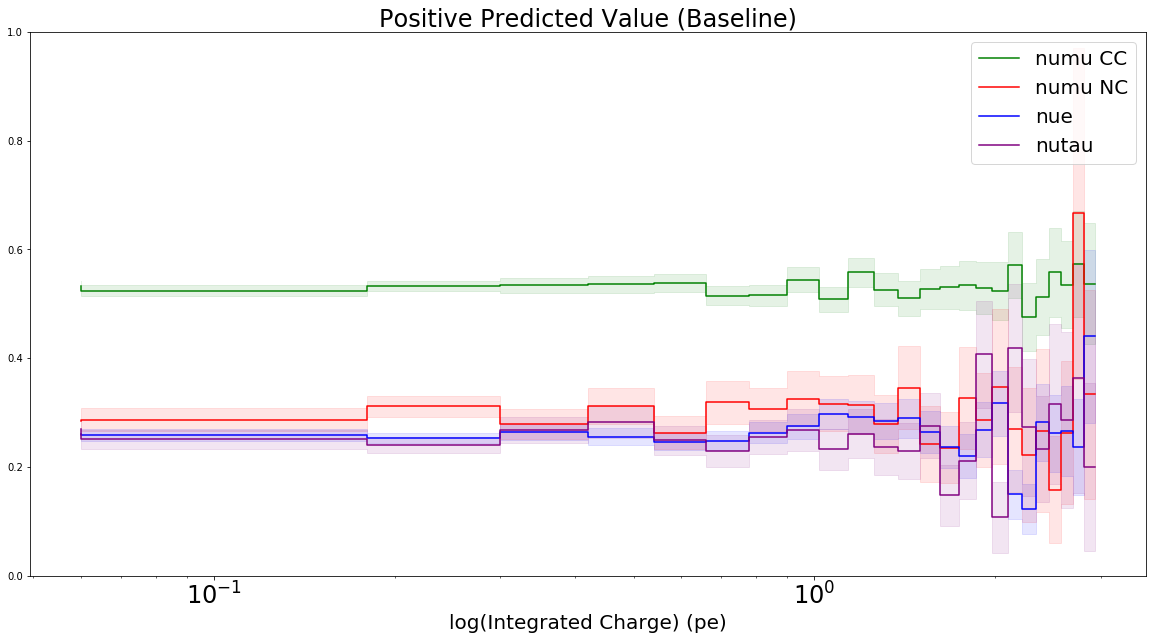

In [22]:
ppr_plot(y_baseline, data_test.targets, charge, pdg_encodings, interaction_types,
        'Positive Predicted Value (Baseline)', plots)

# Check Batchnorm of model

In [23]:
model.graph_convolutions[1].batchnorm.running_variance

tensor([0.2381, 0.5666, 0.8020, 0.7204, 0.4115, 1.5524, 0.2992, 0.2074, 0.4271,
        0.4677, 0.5658, 0.6617, 0.2459, 0.4313, 0.1954, 0.7531, 0.2006, 0.5997,
        0.3360, 0.2329, 0.3991, 0.4691, 0.4634, 0.2969, 0.4063, 0.2544, 0.6110,
        0.3437, 0.2894, 0.3694, 0.2633, 0.1776, 0.4011, 0.6491, 0.2749, 0.2609,
        0.5413, 0.0733, 0.2770, 1.2909, 0.0892, 0.3382, 0.6214, 0.2150, 0.6699,
        0.3866, 0.4290, 0.3344, 0.5841, 0.3007, 0.4760, 0.2497, 0.1136, 0.5204,
        0.7986, 0.2983, 0.1033, 0.5664, 0.3006, 0.7298, 0.1461, 0.1828, 0.4564,
        0.2656], device='cuda:0')

In [24]:
data_test.features.mean(0), data_test.features.std(0)

(array([2.59432413e-01, 3.18244985e-01, 2.75823390e-01, 3.13502575e-01,
        1.14812301e+00, 1.07043561e+00, 1.31100933e+00, 7.65729437e-02,
        1.35385516e-01, 9.29639213e-02, 3.36651782e-01, 6.20712460e-05,
        1.84652407e-03, 3.98547371e-02, 2.92116724e-12, 1.20205732e-11,
        6.71586071e-12]),
 array([0.41890392, 0.47106593, 0.43108752, 0.4120964 , 0.97113636,
        0.49545806, 2.22815572, 0.45855625, 0.49347819, 0.46583408,
        0.34005416, 0.9992484 , 0.99924374, 0.99920548, 0.99923966,
        0.99923966, 1.        ]))

In [25]:
1 / model.kernel.inverse_sigma

tensor([1.3468], device='cuda:0', grad_fn=<MulBackward0>)

In [27]:
# Verify that batchnorm is working in testing mode
for X, y in test_loader:
    break
X, C, M, F = X
y_pred1 = model(X, C, M, F)
y_pred2 = model(X[:32], C[:32], M[:32], F[:32])
(y_pred1[:y_pred2.size(0)] == y_pred2).all()

tensor(1, device='cuda:0', dtype=torch.uint8)

# Evaluate model on filtered testing dataset

In [28]:
import dataset

In [29]:
idx_filter = dataset.hd5.event_filter(data_test.file, min_track_length=70, max_cascade_energy=10)

After Track Length filter 136796 / 220295 events remain.
After Cascade Energy filter 119703 / 220295 events remain.


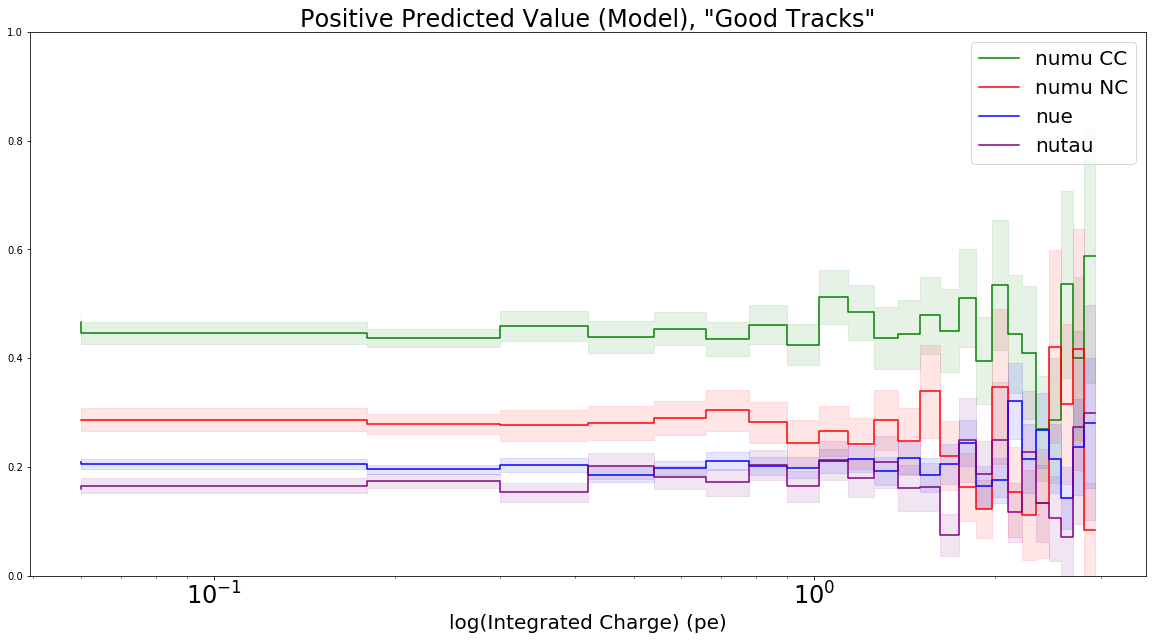

In [31]:
ppr_plot(y_model[idx_filter], data_test.targets[idx_filter], charge[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        'Positive Predicted Value (Model), "Good Tracks"', plots)

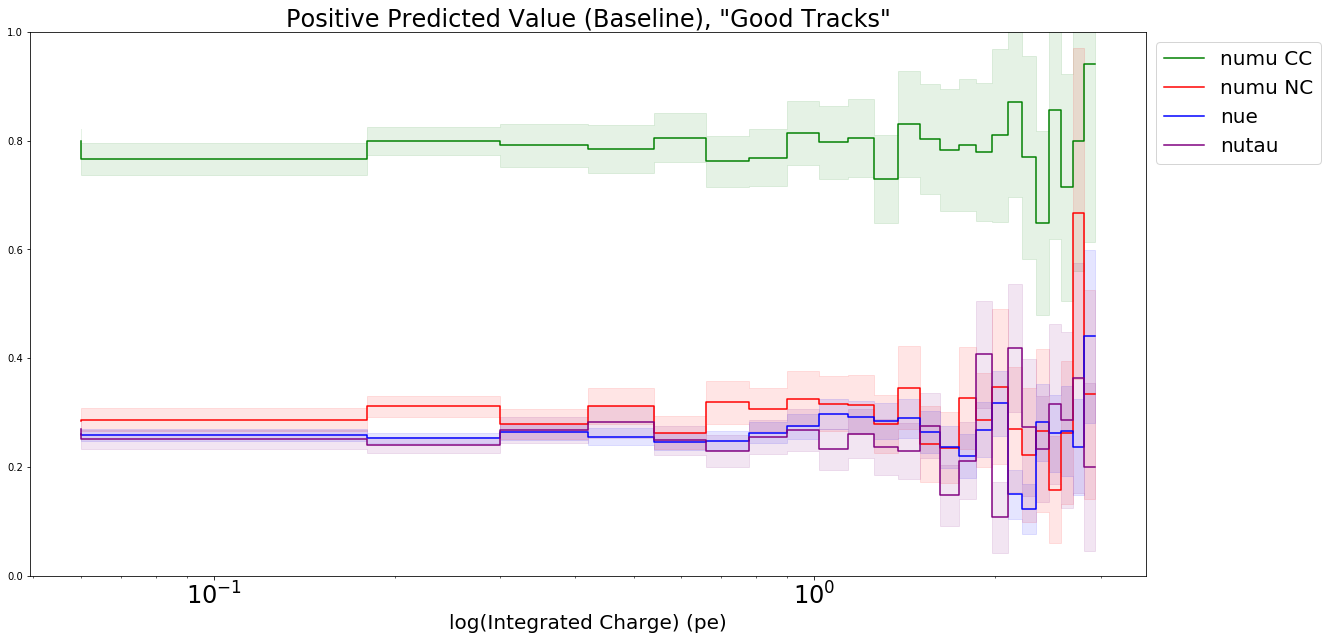

In [32]:
ppr_plot(y_baseline[idx_filter], data_test.targets[idx_filter], charge[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        'Positive Predicted Value (Baseline), "Good Tracks"', plots)

In [33]:
for data in (data_test, data_train, data_val):
    data.file.close()

## Evaluate the model on the big dataset (that contains everything that was filtered)

In [76]:
# Create a generator for the data
def large_data_generator(batch_size):
    # Loop over the dataset
    while True:
        for idx in range(0, large_data_idx.shape[0], batch_size):
            batch_idxs = large_data_idx[idx : idx + batch_size]
            features, coordinates, masks = data.get_padded_batch(batch_idxs)
            yield [features, coordinates, masks]

In [77]:
logits_model_large_data = model.predict_generator(large_data_generator(batch_size),
                       steps=int(np.ceil(large_data_idx.shape[0] / batch_size)), verbose=1)

25244/25244 [==============================] - 233s 9ms/step


In [78]:
y_model_large_data = (logits_model_large_data >= 0.5).astype(np.int).flatten()

In [83]:
y_model_large_data.shape, large_data_idx.shape, charge.shape, pdg_encodings.shape

((1615566,), (1615566,), (2202957,), (65265,))

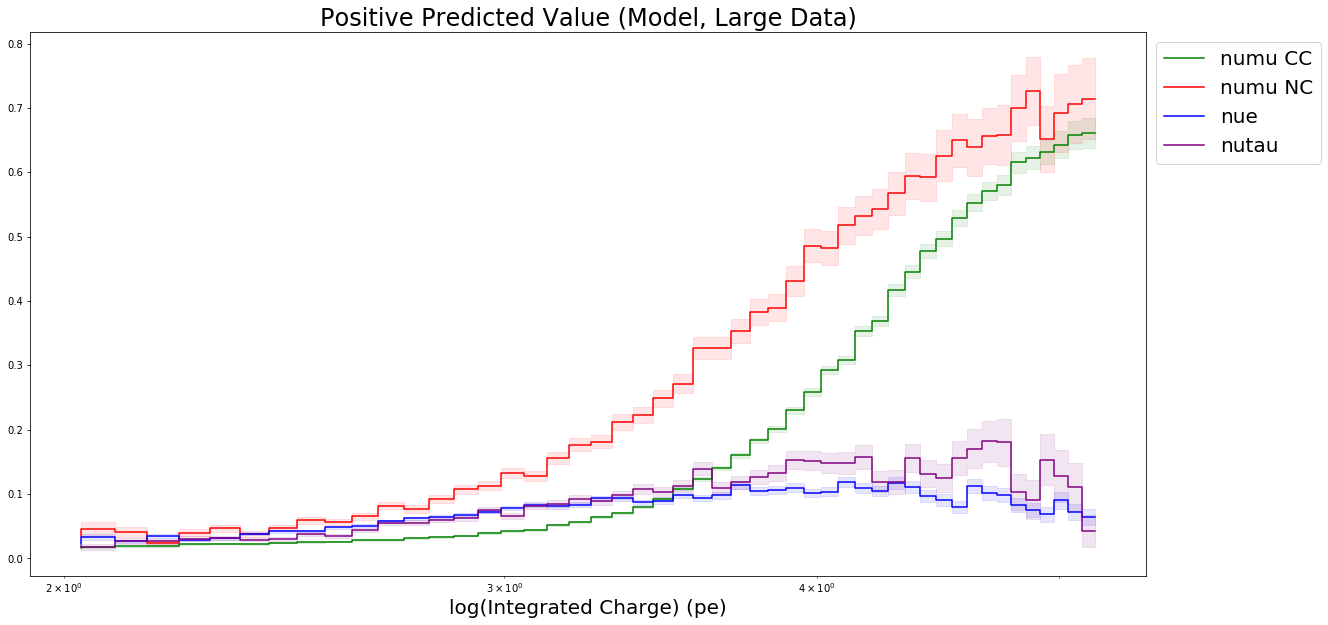

In [87]:
ppr_plot(y_model_large_data, data.targets[large_data_idx], charge[large_data_idx], 
         pdg_encodings[large_data_idx], interaction_type[large_data_idx],
        'Positive Predicted Value (Model, Large Data)', plots)

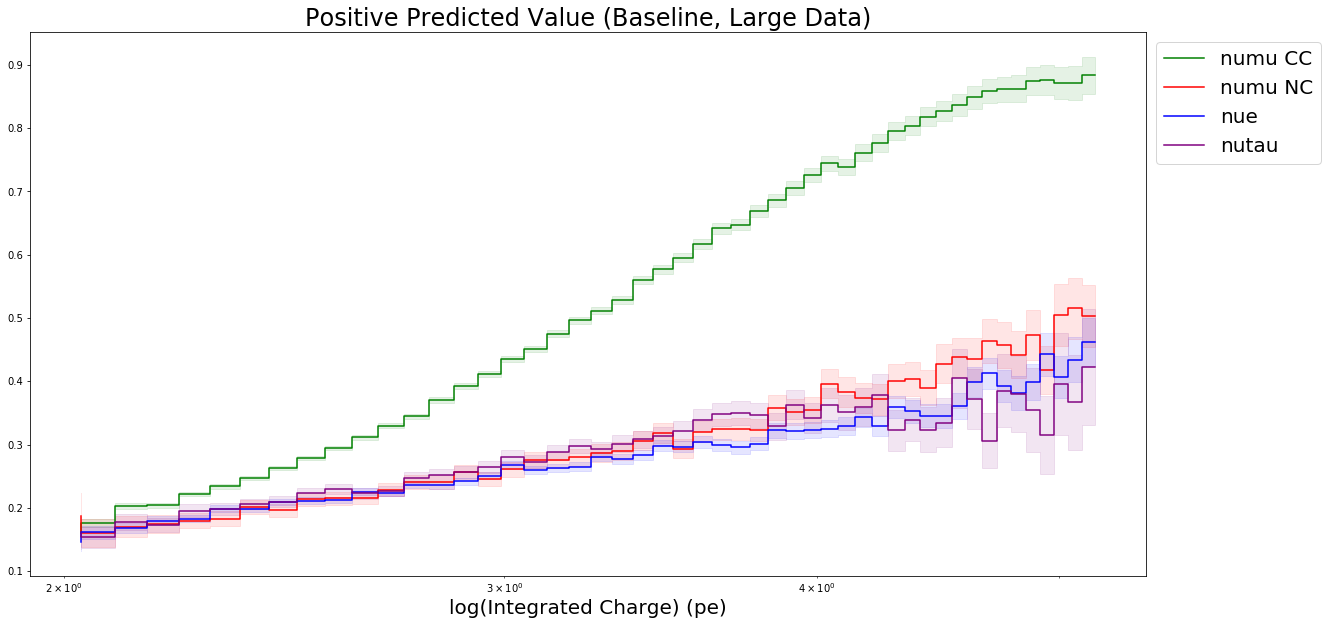

In [86]:
ppr_plot(y_baseline[large_data_idx], data.targets[large_data_idx], charge[large_data_idx], 
         pdg_encodings[large_data_idx], interaction_type[large_data_idx],
        'Positive Predicted Value (Baseline, Large Data)', plots)

In [47]:
acc_model_large_data = (y_model_large_data == data.targets[large_data_idx]).sum() / y_model_large_data.shape[0]
acc_baseline_large_data = (y_baseline[large_data_idx] == data.targets[large_data_idx]).sum() / y_model_large_data.shape[0]
acc_model_large_data, acc_baseline_large_data

(0.37931659864097167, 0.5603441765919808)

<ErrorbarContainer object of 3 artists>

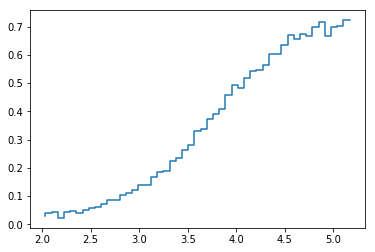

In [49]:
is_numunc = (np.logical_and((np.abs(pdg_encodings) == 14), (interaction_type == 2)))[large_data_idx]
model_preds_numunc = y_model_large_data[is_numunc]
log_charges_numunc = np.log(charge[large_data_idx][is_numunc])

# Bin the charges
bin_counts, bins = np.histogram(log_charges_numunc, bins=50, range=(2.0, 5.2))
bin_counts_positives, _ = np.histogram(log_charges_numunc[model_preds_numunc > 0], bins=bins)
ppr = bin_counts_positives / bin_counts
plt.errorbar(0.5 * (bins[1:] + bins[:-1]), ppr, drawstyle='steps')

# Check NuMu NC predictions from the model

In [50]:
pdg_encodings = data.file['PDGEncoding']['value'][test_idx]
interaction_type = data.file['InteractionType']['value'][test_idx]
# Find positive predictions of the model that are also NuMu NC
model_positives = y_model.astype(np.bool)
is_numu_nc = np.logical_and(interaction_type == 2, np.abs(pdg_encodings) == 14)
numu_nc_positives = np.logical_and(model_positives, is_numu_nc)
numu_nc_positives.sum() / is_numu_nc.sum()
numu_nc_positive_idx = test_idx[numu_nc_positives]

In [56]:
numu_nc_positve_idx_shuffled = numu_nc_positive_idx.copy()
np.random.shuffle(numu_nc_positve_idx_shuffled)
numu_nc_positve_idx_shuffled[:9]

array([132626,  45518, 210986,  88710, 120602, 128937, 190098,  84665,
        58167])

In [69]:
X, D, M = data.get_padded_batch(numu_nc_positve_idx_shuffled[:1000])
logits_ = model.predict_on_batch([X, D, M])

In [71]:
(logits_ > .5).sum()

1

In [51]:
data.file['TrackLength']['value'][numu_nc_positive_idx]

array([nan, nan, nan, ..., nan, nan, nan])

In [52]:
data.file['CascadeEnergy']['value'][numu_nc_positive_idx]

array([ 4.75584811,  2.97221309,  7.37752622, ..., 49.48427969,
        4.56047016, 14.87253192])

In [53]:
data.file['IC86_Dunkman_L6_SANTA_DirectCharge']['value'][numu_nc_positive_idx]

array([ 4.67499995, 12.40000015,  8.67499997, ..., 23.07499993,
       21.20000009, 11.55      ])

In [ ]:
data.file['PDGEncoding']['value'][numu_nc_positive_idx], np.std(np.abs(data.file['PDGEncoding']['value'][numu_nc_positive_idx]))

In [ ]:
data.file['InteractionType']['value'][numu_nc_positive_idx], np.std(data.file['InteractionType']['value'][numu_nc_positive_idx])

In [ ]:
y_model[]

In [ ]:
data.file.keys()

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [ ]:
#run_idx = 'hd5-875239' Model without cutoff but class balancing
run_idx = 'hd5-860835'

In [ ]:
%ls training/{run_idx}

In [ ]:
with open(f'training/{run_idx}/config.json') as f:
    settings = json.load(f)

In [ ]:
data = util.dataset_from_config(settings)

In [ ]:
model = util.model_from_config(settings)

In [ ]:
model.load_weights(f'training/{run_idx}/model_weights.h5')

In [ ]:
model.weights

In [ ]:
data.get_baseline_accuracy()

In [ ]:
#test_idx = data._get_idx('test')
# Also append all idx that were kept from the model
#test_idx.shape

In [ ]:
data2_config = settings
settings['dataset']['max_charge'] = None
settings['dataset']['balance_classes'] = None
settings['dataset']['min_track_length'] = None
settings['dataset']['max_cascade_energy'] = None
data2 = util.dataset_from_config(data2_config)

In [ ]:
test_idx = data2._get_idx('test')
test_idx.shape

In [ ]:
# Evaluate the model on all the data
batch_size = 72
logits_model = model.predict_generator(data2.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data2.size(dataset='test') / batch_size)), verbose=1)

In [ ]:
logits_model

In [ ]:
np.unique(logits_model).shape

In [ ]:
y_model = (logits_model >= 0.5).astype(np.int)

In [ ]:
np.unique(y_model)

In [ ]:
y_model = y_model.squeeze()

In [ ]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [ ]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [ ]:
y_model.shape, y_gnd.shape, y_baseline.shape

In [ ]:
total_charge
total_charge.max(), total_charge.min()

In [ ]:
bins = np.logspace(0.8, 3.2)
binned = np.digitize(total_charge, bins)
#np.unique(binned)

In [ ]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / ((y_gnd == 1).sum() + 1e-20)
    tnr = (y_pred[y_gnd == 0] == 0).sum() / ((y_gnd == 0).sum() + 1e-20)
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [ ]:
pgd_encoding = np.array(data.file['PDGEncoding']['value'], dtype=np.uint8).astype(np.int8)
pgd_encoding.shape

In [ ]:
(np.abs(pgd_encoding) == 12).sum()

In [ ]:
interaction_types = np.array(data.file['InteractionType']['value'], dtype=np.uint8)
interaction_types

In [ ]:
np.unique(pgd_encoding, return_counts=True)

In [ ]:
np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).sum() / interaction_types.shape[0]

In [ ]:
np.unique(interaction_types)

In [ ]:
data.file.keys()

In [ ]:
y_gnd2 = np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).astype(np.int)

In [ ]:
metrics = defaultdict(lambda: defaultdict(list))
for bin_idx, value in enumerate(bins):
    for interaction_type, pgd_code in (('nue', 12), ('numu CC', 14), ('numu NC', 14), ('nutau', 16)):
        # print((np.abs(pgd_encoding) == pgd_code).sum(), pgd_code)
        bin_mask = binned == bin_idx
        enc_mask = np.abs(pgd_encoding[test_idx] == pgd_code)
        if 'numu' in interaction_type:
            it = 1 if 'CC' in interaction_type else 2
            it_mask = interaction_types[test_idx] == it
            #print(it, it_mask.sum())
            idxs = np.where(np.logical_and(bin_mask, np.logical_and(enc_mask, it_mask)))[0]
        else:
            idxs = np.where(np.logical_and(bin_mask, enc_mask))[0]
        # print(idxs.shape)
        for y, t in ((y_model, 'model'), (y_baseline, 'baseline')):
            acc, tpr, tnr, ppr = get_metrics(y[idxs], y_gnd[idxs])
            metrics[interaction_type][t].append({
                'acc' : acc, 'tpr' : tpr, 'ppr' : ppr, 'bin_idx' : bin_idx, 'value' : value, 'num_samples' : idxs.shape[0]
            })

In [ ]:
dfs = {
    pgd_code : {
            type_ : pd.DataFrame(data) for type_, data in metrics_code.items()
        } for pgd_code, metrics_code in metrics.items()
    }
for pgd_code, metrics_code in dfs.items():
    for type_, df in metrics_code.items():
        df = df[df['num_samples'] > 100]
        metrics_code[type_] = df

In [ ]:
dfs['numu NC']

In [ ]:
def plot_metric(metric, metric_name):
    colors = ['blue', 'green', 'red', 'purple']
    fig = plt.figure()
    plt.xscale('log')
    for (pgd_code, df), color in zip(dfs.items(), colors):
        for t in df.keys():
            if t == 'model':
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (model)', color=color)
            else:
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (baseline)', linestyle='dashed', color=color)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(metric_name)
    plt.ylim()
    plt.xlabel('log(Integrated Charge) (pe)')


In [ ]:
plot_metric('acc', 'Accuracy', )

In [ ]:
(y_model == y_gnd).sum() / y_gnd.shape[0]

In [ ]:
(y_baseline == y_gnd).sum() / y_gnd.shape[0]

In [ ]:
plot_metric('ppr', 'Predicted Positives')

In [ ]:
bins_track, bin_counts_track = np.unique(binned[y_gnd > 0], return_counts=True)
bins_non_track, bin_counts_non_track = np.unique(binned[y_gnd <= 0], return_counts=True)
bin_counts_non_track, bin_counts_track


In [ ]:
fig = plt.figure()
plt.xscale('log')
plt.step(bins[bins_track], bin_counts_track, label='Track')
plt.step(bins[bins_non_track], bin_counts_non_track, label='No Track')
plt.legend()
plt.xlim(right=2e2)
plt.title('Event Counts')
plt.xlabel('log(Integrated Charge) (pe)')

In [ ]:
np.hstack((
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc']),
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc'])
    )
)

In [ ]:
total_charge_sorted = np.sort(total_charge)

In [ ]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [ ]:
y_model.shape, y_gnd.shape

In [ ]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



In [ ]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [ ]:
model.summary()

In [ ]:
model.weights

In [ ]:
np.unique(y_model)

# Investigate attributes of the dataset

In [ ]:
file = h5py.File('../data/data_dragon2.hd5')

In [ ]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [ ]:
samples = idx[:100000]

In [ ]:
file.keys()

In [ ]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [ ]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [ ]:
time_std_samples

In [ ]:
plt.hist(time_std_samples, bins=100)

In [ ]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [ ]:
charge_samples = charge_samples[charge_samples <= 5]

In [ ]:
plt.hist(charge_samples, bins=100)

In [ ]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [ ]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [ ]:
time_samples_filtered.std()